# SegNet 2 Hyperparameter Tuning 

* This repo contains code that appears to be similar to the attempted AWS training code
* If it successful, the library used here can be adapted on the sagemaker platform

In [37]:
# import the model
from segnet2 import SegNet

In [2]:
#################### Imports #########################
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from collections import OrderedDict
import time
import numpy as np
from torch.autograd import Variable
from pathlib import Path
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
multiGPU = False
##### Tensor board requirements
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Data Processing

In [7]:
############### data class ################
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [4]:
############# Import Data #############
base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')

#Check data length, should be 8400
len(data)

8400

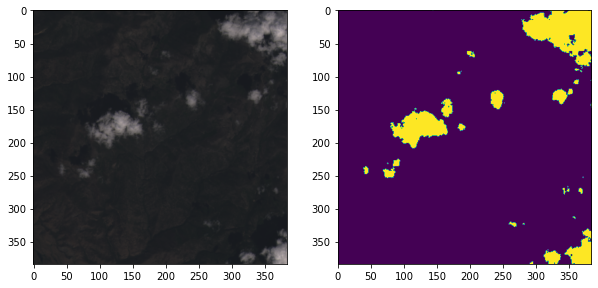

In [5]:
########### Inspect data ##########
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(150))
ax[1].imshow(data.open_mask(150))

In [6]:
############ Split the dataset into train and validation ########

train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))


# Hyperparameter Tuning
* This is the first attempt at runing a hyperparameter tuning job
code: https://github.com/optuna/optuna/blob/master/examples/pytorch_simple.py

In [10]:
%pip install optuna

  Using cached optuna-2.1.0.tar.gz (232 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached cmaes-0.6.1-py3-none-any.whl (9.7 kB)
  Using cached colorlog-4.2.1-py2.py3-none-any.whl (14 kB)
     |████████████████████████████████| 1.3 MB 11.6 MB/s eta 0:00:01
  Using cached alembic-1.4.3-py2.py3-none-any.whl (159 kB)
  Using cached cliff-3.4.0-py3-none-any.whl (76 kB)
  Using cached python_editor-1.0.4-py3-none-any.whl (4.9 kB)
  Using cached Mako-1.1.3-py2.py3-none-any.whl (75 kB)
  Using cached cmd2-1.3.10-py3-none-any.whl (132 kB)
  Using cached stevedore-3.2.2-py3-none-any.whl (42 kB)
  Using cached pbr-5.5.0-py2.py3-none-any.whl (106 kB)
  Using cached pyperclip-1.8.0.tar.gz (16 kB)
  Created wheel for optuna: filename=optuna-2.1.0-py3-none-any.whl size=321039 sha256=e5b80f78532606c1db9be2d4bdcde6fcc7bad979d1838f38937ca1038242d581
  Stored in directory: /home/jupyter/.cache/pip/wheels/d8/a5/

In [40]:
"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.
In this example, we optimize the validation accuracy of hand-written digit recognition using
PyTorch and MNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole MNIST dataset, we here use a small
subset of it.
"""

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

import optuna


DEVICE = torch.device("cpu")
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    label_no = 2 # assuming cloud and non cloud
    input_no = 4 # for the cloud data, for now
    model = SegNet(input_no,label_no)
    return model


def get_clouds():
    base_path = Path('38-Cloud_training')
    data = CloudDataset(base_path/'train_red', 
                        base_path/'train_green', 
                        base_path/'train_blue', 
                        base_path/'train_nir',
                        base_path/'train_gt')
    
    batch_size = 4

    train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    return train_dl, valid_dl


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the MNIST dataset.
    train_loader, valid_loader = get_clouds()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

           # data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-09-23 23:06:16,715] A new study created in memory with name: no-name-14b9caaf-8fb2-4883-8cf6-c3693fd35fd8
[I 2020-09-24 00:28:38,410] Trial 0 finished with value: 2622.15234375 and parameters: {'optimizer': 'SGD', 'lr': 0.019198653444780417}. Best is trial 0 with value: 2622.15234375.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  2622.15234375
  Params: 
    optimizer: SGD
    lr: 0.019198653444780417


# Conclusion
* the reliability of the results cannot be determined until they can be compared with another hyperparameter tuning tool
* sagemaker hyperparameter tuning will be used on the sagemaker platform and can be customised from there
* the run appeared to only do one trial